In [207]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

# Comparison of Classifiers for Breast Cancer Prediction

The objective in this assignment is to create both a decison tree classifier and a naive bayes classifier for the Breast Cancer Prediction dataset, and to compare their performance. What is the best algorithm for the dataset?

In [208]:
data_frame = pd.read_csv('data/wdbc.data', header=None).astype('category')
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Introduction:
In this project i am going to analyze a dataset aimed at predicting whether a patient has breast cancer based on features describing breast masses. The goal is to identify relationships between various characteristics of the breast mass (the features) and the diagnosis of the condition (the target). By building a model trained on this data, we aim to create a predictive tool capable of accurately diagnosing breast cancer, which can assist in improving decision-making in medical contexts.   
      
features: The dataset contains 30 continuous features that describe the characteristics of breast mass, extracted from Fine Needle Aspiration (FNA) images. These features include measurements such as the radius, texture, compactness, and smoothness of the breast tissue  
   
Target: The target variable represents a binary classification problem: the target is categorical, with two possible outcomes: the patient either has breast cancer (B) or does not have breast cancer (M). 

The steps I will follow to identify the best model include:
        1. Analyzing and Preprocessing the Data: Cleaning and preparing the dataset for training  
        2. Splitting the data: Dividing the dataset into training, validation, and testing sets  
        3. Hyperparameter Tuning: I will be using nested grid search to find the best parameters for each model  
        4. Model evaluation: evaluating using accuracy, precision, recall, the f-measure and roc-auc to conclude which is the best model.  
   
By following these steps, we can gain valuable insights into the dataset, refine it for modeling, and ultimately identify which model (Decision Tree Classifier or Naive Bayes) performs better. This process will not only help understand the relationships between the features and the target variable but also provide a reliable model for predicting breast cancer.

# Analysis and pre-processing of data:

# remove unecessary columns
the only comlumn that needed to be removed was the ID, because this will not give us any information about the diagnosis. The rest of the columns give information about the breast mass, and therefore are needed to get the best diagnosis

I converted all the columns to numerical types because the hist function did not recognize the values as numerical. Initially, the columns were interpreted as strings (or categorical), which prevented proper plotting of histograms. It is easier to work with a machine learning problem with all numerical values

In [210]:
data_frame = data_frame.drop(0, axis=1)
data_frame[1] = data_frame[1].map({'M': 0, 'B': 1})
data_frame = data_frame.apply(pd.to_numeric, errors='coerce')
data_frame.head()



,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Distribution analysis
When choosing the appropriate type of Naive Bayes to use, it's essential to examine distribution of the data. The histograms reveal that all features are normally distributed. Given this distribution, Gaussian Naive Bayes is the most suitable choice for this dataset. The features are not perfectly normally distributed, but it still is close enough.
  
target distribution: the target is column nr 1, which is the binary distributed column. we can see that there is some imbalance in the target distribution, there are more 1 then 0. the difference is not huge, there is enough representation of both groups.

array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>,
        <Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>, <Axes: title={'center': '6'}>],
       [<Axes: title={'center': '7'}>, <Axes: title={'center': '8'}>,
        <Axes: title={'center': '9'}>, <Axes: title={'center': '10'}>,
        <Axes: title={'center': '11'}>, <Axes: title={'center': '12'}>],
       [<Axes: title={'center': '13'}>, <Axes: title={'center': '14'}>,
        <Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>, <Axes: title={'center': '18'}>],
       [<Axes: title={'center': '19'}>, <Axes: title={'center': '20'}>,
        <Axes: title={'center': '21'}>, <Axes: title={'center': '22'}>,
        <Axes: title={'center': '23'}>, <Axes: title={'center': '24'}>],
       [<Axes: title={'center': '25'}>, <Axes: title={'center': '26'}>,
        <Axes: title={'center': '27'}>, <Axes: title={'center': '28'}

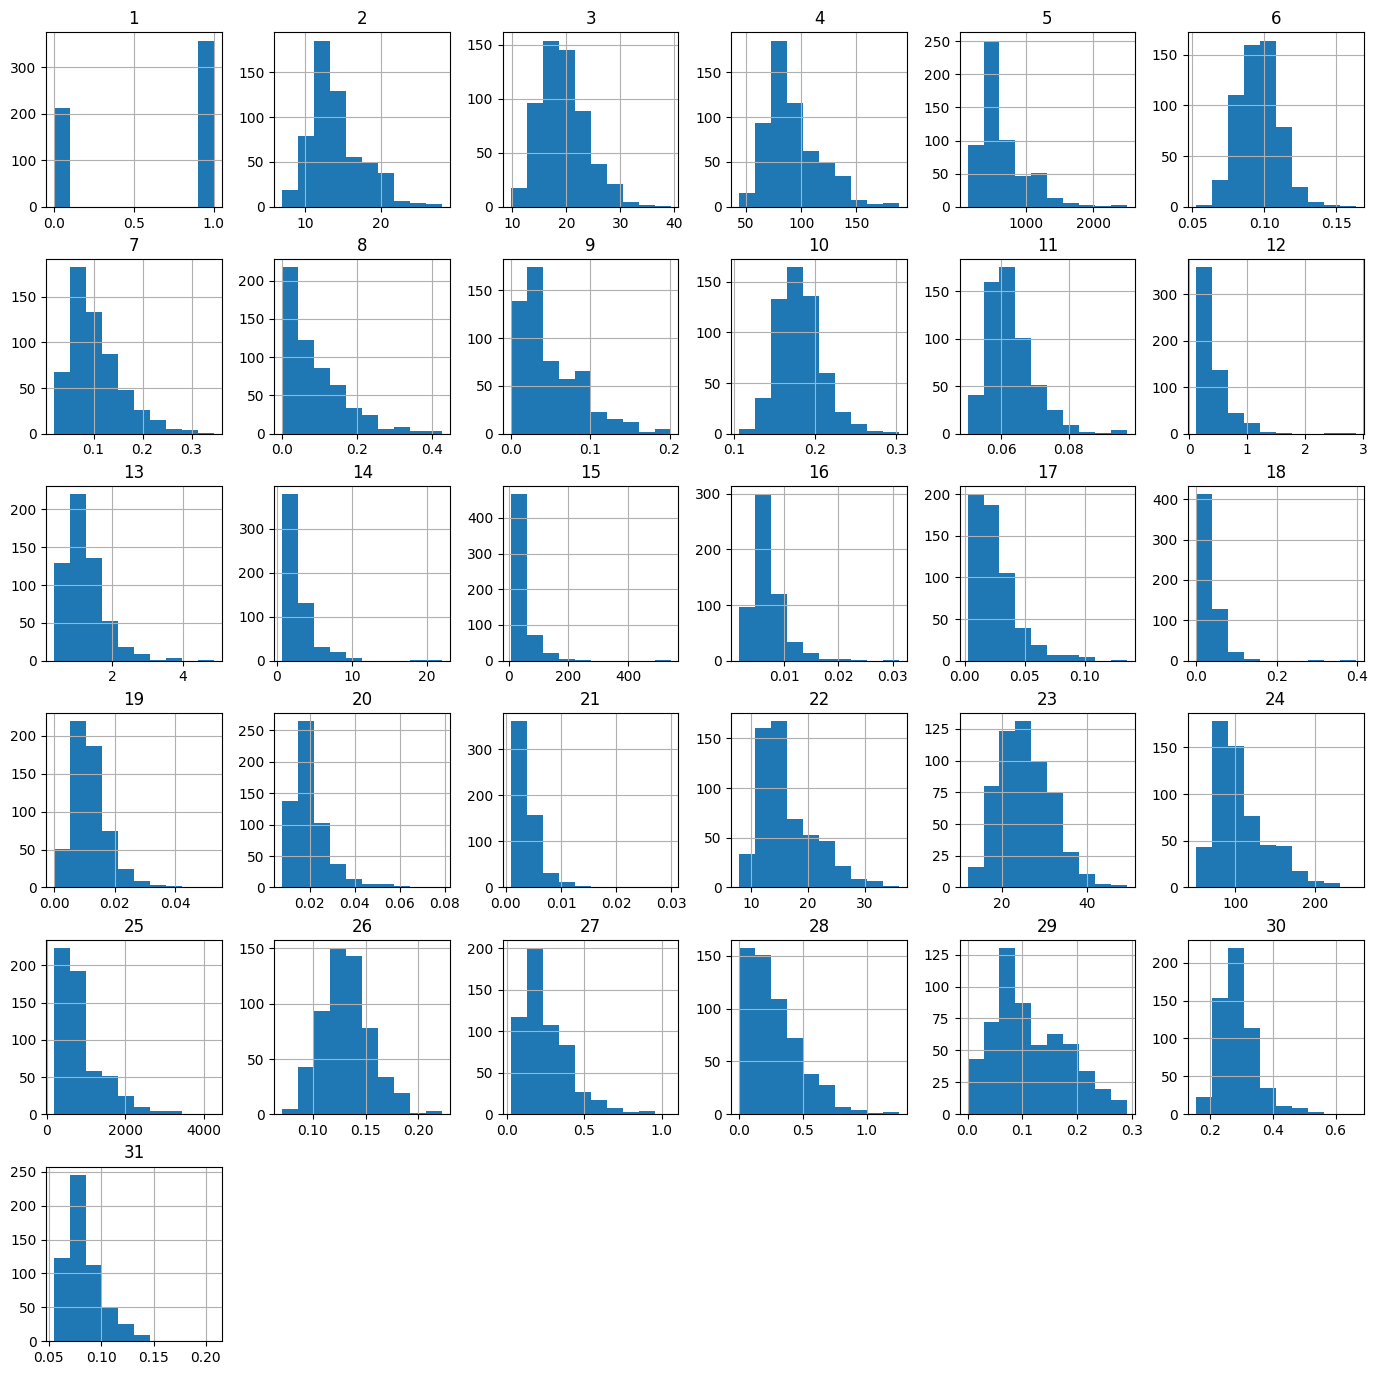

In [211]:
data_frame.hist(figsize=(17, 17))

# correlation analysis
We can see that there are many features with high correlation, we can use column transform to combine those columns with high correlation.  
the columns with the highest correlation:  
    -2, 4, 5, 22, 24, 25
    -7, 8, 9, 27, 28, 29
    -12, 14, 15


In [212]:
data_corr = data_frame.corr()
data_corr.style.background_gradient(cmap='coolwarm')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
1,1.000000,-0.730029,-0.415185,-0.742636,-0.708984,-0.358560,-0.596534,-0.696360,-0.776614,-0.330499,0.012838,-0.567134,0.008303,-0.556141,-0.548236,0.067016,-0.292999,-0.253730,-0.408042,0.006522,-0.077972,-0.776454,-0.456903,-0.782914,-0.733825,-0.421465,-0.590998,-0.659610,-0.793566,-0.416294,-0.323872
2,-0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
3,-0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
4,-0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
5,-0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
6,-0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
7,-0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,0.497473,0.046205,0.548905,0.455653,0.135299,0.738722,0.570517,0.642262,0.229977,0.507318,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
8,-0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,0.631925,0.076218,0.660391,0.617427,0.098564,0.670279,0.691270,0.683260,0.178009,0.449301,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
9,-0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
10,-0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,0.303379,0.128053,0.313893,0.223970,0.187321,0.421659,0.342627,0.393298,0.449137,0.331786,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


# combine the correlations in a pipeline using column transform:
Since PCA can impact the performance of models, we will incorporate it into a pipeline. This will allow us to evaluate the model's performance with and without PCA, helping us determine whether PCA actually improves the results compared to using the original dataset.  
first i have to check what number of dimention reduction works best for the correlated columns, this way i can make sure i keep enough information about the dataset. then i can put every pca in the column transform with the right number of column reduction.

for columns 2, 4, 5, 22, 24 and 25, we can see there is enough information and explained variance if we just reduce the dimentionality to 2. 

[0.98361747 0.99986678 0.99999249 0.99999959 0.99999996 1.        ]


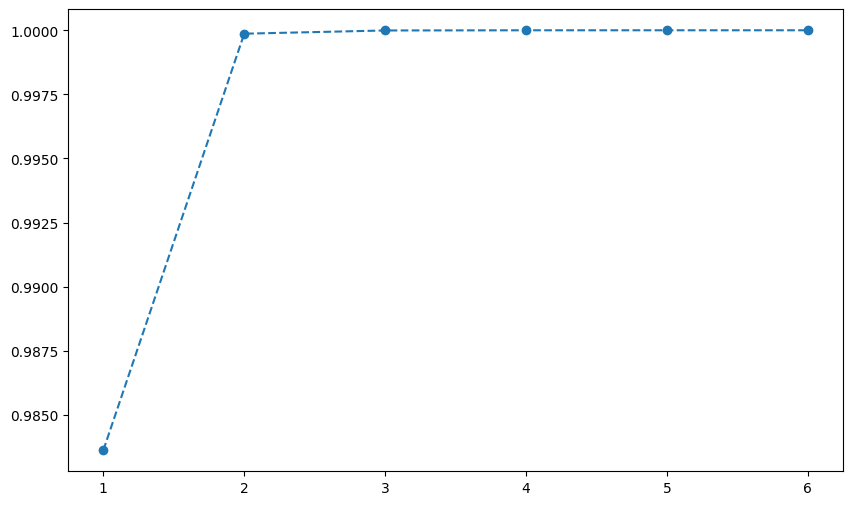

In [213]:
pca = PCA()
number_of_pca = pca.fit_transform(data_frame.iloc[:, [1, 3, 4, 21, 23, 24]])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

for columns the 6, 7, 8, 26, 27 and 28, we can see there is enough information and explained variance if we just reduce the dimentionality to 3. 

[0.91358142 0.96152484 0.98851967 0.99762152 0.99947994 1.        ]


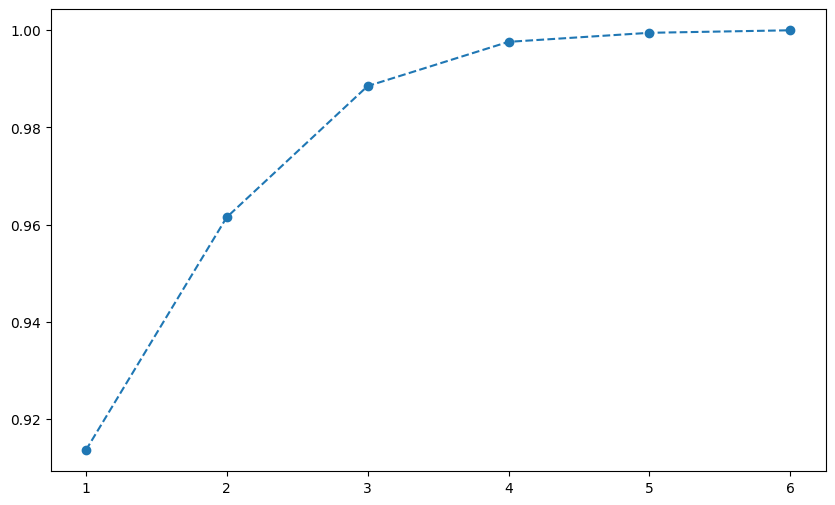

In [214]:
pca = PCA()
number_of_pca = pca.fit_transform(data_frame.iloc[:, [6, 7, 8, 26, 27, 28]])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

for columns the 11, 13 and 14, we can see there is enough information and explained variance if we just reduce the dimentionality to 1. 

[0.99975879 0.99999851 1.        ]


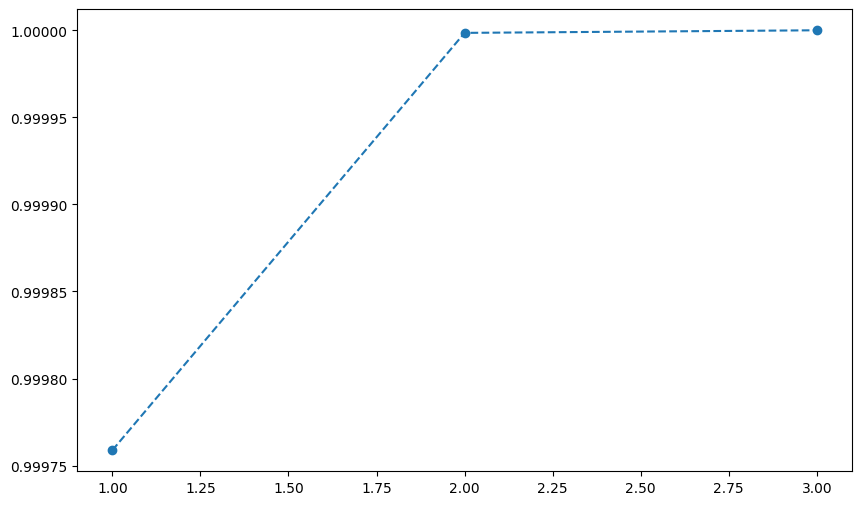

In [215]:
pca = PCA()
number_of_pca = pca.fit_transform(data_frame.iloc[:, [11, 13, 14]])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

In [216]:
# a number lower to find the index
pca = ColumnTransformer([
     ("pca1", PCA(2), [1, 3, 4, 21, 23, 24]),
     ("pca2", PCA(3), [6, 7, 8, 26, 27, 28]),
     ("pca3", PCA(1), [11, 13, 14])   
     ], remainder='passthrough') # keeping the unchanged columns

def pipe_pca(model):
    return Pipeline([('pca', pca), ('classifier', model)])

# spliting the data:
I am splitting the data into training-validation and test. The trai_val data will make up 80% of the dataset, while the test data will account for 20%. Since I will be using grid search, the training data will be further divided into training and validation sets at different stages during the grid search process. Once we identify the best model, we can be confident that it is based on the entire training dataset, which helps reduce the risk of overfitting. The train_val data should be the largest section because it needs to be substantial enough to provide sufficient data for training the model, while also allowing for a validation section to monitor the model's progress during training. This is why 80% of the total data is allocated to the train_val set. The test data should also be large enough to effectively evaluate how the model performs on unseen data. Therefore, allocating 20% of the total dataset for testing is typically sufficient.  
  
how the train_val data will be split in nested grid search:  
outer loop(5-cross validation folds):   
    - 80% of the entire dataset is split into five sections  
    - 4/5 (80%) of the train_val data is used for the grid search  
    - 1/5 (20%) of the train_val data is used to evaluate the best model returned from the grid search. which will be unseen data and not used to train the model in the inner loop
inner loop(4-corss validation folds):   
    -In the inner loop, 64% of the entire dataset (which is 80% of the train_val data) is used  for hyperparameter tuning and cross-validation within the grid search process  
    - 3/4 (75%) of the 64% data is used for training the model.
    - 1/4 (25%) of the 64% data is used for validation during the grid search, helping to tune the hyperparameters.  
Since cross-validation is used, the data in the inner and outer loops will be rotated. Each section will be used for both training and validation in different rounds. 

In [ ]:
features = data_frame.drop(1, axis=1)
targets = data_frame[1]

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

# making the model and hyperparameter tuning
things to consider when hyperparameter tuning a good model for this classification problem:  
most important:  
not overfitted:  
It is important to have a model that is not overfitted, meaning the performance on the training data should not be significantly better than on the validation data/test data. A model that performs well on training data but poorly in practice is not useful.
    
good recall: this measures the ability of the model to correctly identify all the actual positive cases (patients with cancer). In a medical context, missing a positive case (false negative) can be very dangerous as it would mean not diagnosing someone who actually has the disease.
  
good precision: A high precision means that the number of false positives (people wrongly diagnosed with cancer) is minimized
  
good F1: the model has good precision and recall  
  
also important:  
good accuracy: the model has good overall preidicions
good roc-auc: provides an aggregate measure of a model's ability to discriminate between classes across different thresholds
  
  
Hyperparameter tuning:  
i will be using nested grid search to find the best model of each model type. This is the optimal way to find the best parameters since it will test every parameter combination multiple times. 

# function to evaluate

In [78]:
def evaluate(estimator, X, y):
    probabilities = estimator.predict_proba(X)
    prediction_indices = np.argmax(probabilities, axis=1)
    predictions = estimator.classes_.take(prediction_indices, axis=0)

    return {
        'accuracy': accuracy_score(y, predictions), 
        'precision': precision_score(y, predictions), 
        'recall': recall_score(y, predictions), 
        'f1': f1_score(y, predictions), 
        'roc_auc': roc_auc_score(y, probabilities[:,1]), 
        }

# nested grid search function

In [89]:
def find_best_models(model, dt_params):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
    }

    for (train_index, test_index) in list(outer_cv.split(train_val_features, train_val_targets)):

        dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='f1',return_train_score=True)
        dt_grid.fit(train_val_features.iloc[train_index], train_val_targets.iloc[train_index])

        cv_results = pd.DataFrame(dt_grid.cv_results_)
        dt_cv_results.append(cv_results)
        dt_estimators.append(dt_grid.best_estimator_)

        evaluation = evaluate(dt_grid, train_val_features.iloc[test_index], train_val_targets.iloc[test_index])
        dt_test_scores['accuracy'].append(evaluation['accuracy'])
        dt_test_scores['precision'].append(evaluation['precision'])
        dt_test_scores['recall'].append(evaluation['recall'])
        dt_test_scores['f1'].append(evaluation['f1'])
        dt_test_scores['roc_auc'].append(evaluation['roc_auc'])
    return dt_estimators, dt_cv_results, dt_test_scores



# Decision tree regressor
parameters i will tune, which are the most important:  

The criterion determines how the quality of a split is measured. The Decision Tree classifier supports the following options:  
    gini: It measures how often a randomly chosen element would be incorrectly classified if it were randomly assigned to a class  
    entropy: It measures the amount of disorder or uncertainty in the data    
    log_loss: measures how well the predicted probabilities from the model match the actual labels   
  
max_depth: this limits the maximum depth of the tree. Setting a limit on the depth is one of the most effective ways to prevent overfitting. A deeper tree can perfectly fit the training data but may not generalize well to unseen data. 
  
splitter: The splitter defines how the model decides where to split at each node:
    -best: This option selects the best possible split based on the criterion chosen. It finds the optimal split at each node but can lead to deeper trees and potentially overfitting
    -random: This option randomly selects a subset of features to split on at each node. This can reduce overfitting and speed up training by introducing randomness


min_samples_split: The min_samples_split defines the minimum number of samples required to split an internal node. Lower values allow the tree to grow deeper, but can become to complex. Higher numbers requires more samples to split a node, which makes the model more general
  
min_samples_leaf: The min_samples_leaf parameter defines the minimum number of samples required at a leaf node. A higher value ensures that each leaf node contains enough samples(underfitting), A lower value might result in small leaf nodes with very few data points(overfitting)
  
max_features: The max_features defines the maximum number of features to consider when looking for the best split. Too many features can lead to overfitting because the model gets more data to work with, too low number of features lead to underfitting and a model that has too little information. 
  
  
The GridSearchCV will help identify the best combination of hyperparameters that perform well on both the training and validation datasets. To ensure that the parameters chosen are optimal, I will also verify that I have selected the correct range of hyperparameters to test. This will be done by plotting the results of each hyperparameter, with each one displayed in its own graph. By doing so, I can visually inspect whether there is a clear peak in the performance metrics, indicating that the range of tested parameters is suitable for achieving the best model performance.
  
since decision tree has very many parameters and this dataset is a bit bigger, i will test parameters in two rounds so the run time dosen't get to high. this way i can still try a wide range of parameters. it is not the optimal way to parameter tune, but since it takes too long it is better then not trying enough parameters.

# Decision tree with original dataset
i tested with different parameter ranges, to make sure i found a peak.

In [236]:
dt_params = {
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': range(4,10),
        'min_samples_split': range(6,10),
        'min_samples_leaf': range(2, 5),
        'max_features': range(25,31),
        'splitter': ['best', 'random']
    }
best_models_decision_tree, cv_results, test_scores_decision_tree = find_best_models(DecisionTreeClassifier(), dt_params)

# plotting the parameters and scores in each their graph
The selected ranges for max depth, min samples split, min samples leaf, and max features appear to be appropriate. max_depth, min samples split and min sample leaf have a clear peak. max_features seems to be the best around the max amount of features which around 30.  
i tested all parameters from criterion and splitter, criterion entropy gave the best score and splitter 'best' also was better then random.

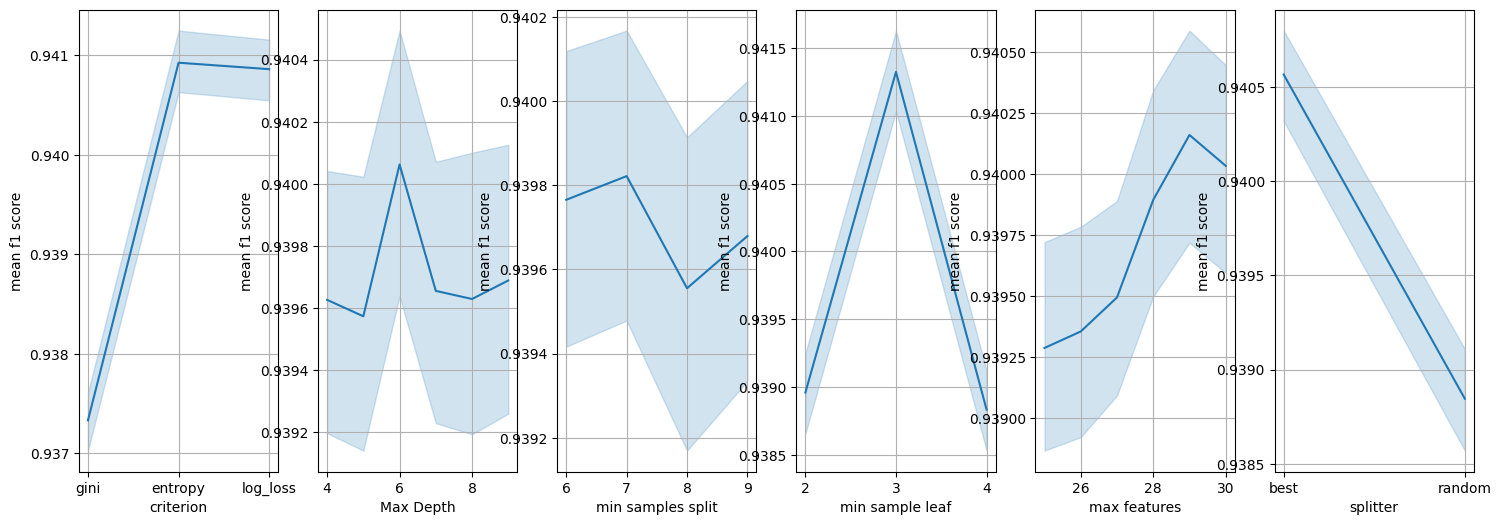

In [244]:
cv_results_df = pd.concat(cv_results, ignore_index=True)

plt.figure(figsize=(18, 6))

plt.subplot(1, 6, 1)
sb.lineplot(data=cv_results_df, x='param_criterion', y='mean_test_f1', estimator='mean')
plt.xlabel('criterion')
plt.ylabel('mean f1 score')
plt.grid()

plt.subplot(1, 6, 2)
sb.lineplot(data=cv_results_df, x='param_max_depth', y='mean_test_f1', estimator='mean')
plt.xlabel('Max Depth')
plt.ylabel('mean f1 score')
plt.grid()

plt.subplot(1, 6, 3)
sb.lineplot(data=cv_results_df, x='param_min_samples_split', y='mean_test_f1', estimator='mean')
plt.xlabel('min samples split')
plt.ylabel('mean f1 score')
plt.grid()

plt.subplot(1, 6, 4)
sb.lineplot(data=cv_results_df, x='param_min_samples_leaf', y='mean_test_f1', estimator='mean')
plt.xlabel('min sample leaf')
plt.ylabel('mean f1 score')
plt.grid()

plt.subplot(1, 6, 5)
sb.lineplot(data=cv_results_df, x='param_max_features', y='mean_test_f1', estimator='mean')
plt.xlabel('max features')
plt.ylabel('mean f1 score')
plt.grid()

plt.subplot(1, 6, 6)
sb.lineplot(data=cv_results_df, x='param_splitter', y='mean_test_f1', estimator='mean')
plt.xlabel('splitter')
plt.ylabel('mean f1 score')
plt.grid()

# finding the best model from the grid search
the list contains 5 models, one from every outer grid search loop. 

In [243]:
for classifier in best_models_decision_tree:
    print(classifier)

DecisionTreeClassifier(criterion='log_loss', max_depth=5, max_features=30,
                       min_samples_leaf=4, min_samples_split=8,
                       splitter='random')
DecisionTreeClassifier(max_depth=8, max_features=27, min_samples_leaf=4,
                       min_samples_split=9, splitter='random')
DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features=25,
                       min_samples_leaf=2, min_samples_split=8,
                       splitter='random')
DecisionTreeClassifier(criterion='log_loss', max_depth=8, max_features=26,
                       min_samples_leaf=3, min_samples_split=7,
                       splitter='random')
DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=27,
                       min_samples_leaf=2, min_samples_split=7,
                       splitter='random')


# the best model
the best criterion: log_loss or entropy, but from the graph above it looks like entropy is a little bit better on average
max_depth: max_depth around 8 is most occuring
max_featutres: values around the max number of features ist most occuring, 27 is in the middel
min_samples_split: the median value here is 8, the other numbers are close to that also
min_samples_leaf: i will choose 3 as the best, since it occurs two times and is in the middel fo 4 and 2.
splitter: the best splitter is random every time.


In [245]:
best_model_df_original_data = DecisionTreeClassifier(criterion='log_loss', max_depth=8, max_features=27, min_samples_split=8, min_samples_leaf=3, splitter='random')
best_model_df_original_data.fit(train_val_features, train_val_targets)
evaluate(best_model_df_original_data, test_features, test_targets)

{'accuracy': 0.9473684210526315,
 'precision': 0.9452054794520548,
 'recall': 0.971830985915493,
 'f1': 0.9583333333333334,
 'roc_auc': 0.9775630527350148}

# decision tree with pca data

In [229]:
dt_params = {
        'classifier__criterion': ['gini', 'entropy', 'log_loss'], 
        'classifier__max_depth': range(4,10),
        'classifier__min_samples_split': range(6,10),
        'classifier__min_samples_leaf': range(2, 5),
        'classifier__max_features': range(25,31),
        'classifier__splitter': ['best', 'random']
    }
best_models_decision_tree_pca, cv_results, test_scores_decision_tree_pca = find_best_models(pipe_pca(DecisionTreeClassifier()), dt_params)

# finding the best model from the grid search
the list contains 5 models, one from every outer grid search loop. 

In [241]:
for classifier in best_models_decision_tree_pca:
    print(classifier)

Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=2),
                                                  [1, 3, 4, 21, 23, 24]),
                                                 ('pca2', PCA(n_components=3),
                                                  [6, 7, 8, 26, 27, 28]),
                                                 ('pca3', PCA(n_components=1),
                                                  [11, 13, 14])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9,
                                        max_features=29, min_samples_leaf=2,
                                        min_samples_split=8,
                                        splitter='random'))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components

# the best model
criterion: log_loss is the most occuring  
max_depth: i will choose 7 as the best, it is the number in the middel of the occuring once  
max_features: i will choose 28, most occuring and most of the other features are closer to this value  
min_saples_split: min samples split 7 is the best
min_samples_leaf: min samples leaf 3 is the most occuring
splitter: 'random' is the most occuring



In [247]:
best_model_df_pca = pipe_pca(DecisionTreeClassifier(criterion='log_loss', max_depth=7, max_features=28, min_samples_split=7, min_samples_leaf=3, splitter='random'))
best_model_df_pca.fit(train_val_features, train_val_targets)
evaluate(best_model_df_pca, test_features, test_targets)

{'accuracy': 0.956140350877193,
 'precision': 1.0,
 'recall': 0.9295774647887324,
 'f1': 0.9635036496350365,
 'roc_auc': 0.9972158532590893}

# which dataset to continue with
for decisiontree it looks like the results from the dataset with pca is sligntly better then the orignal dataset. almost all of the metrics are better beside recall, but since f1 is higher in the altered data it is better. the results are pretty close though.

# Naive Bayes

# Naive Bayes with original dataset

In [248]:
NB_params = {
        'var_smoothing': np.logspace(-2, -12, num=11), 
    }
best_models_NB_original, cv_results, test_scores_NB = find_best_models(GaussianNB(), NB_params)

# display parameters in graphs

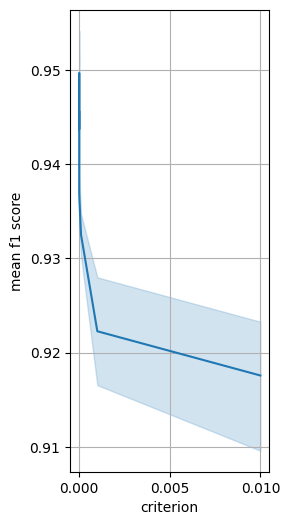

In [251]:
cv_results_df = pd.concat(cv_results, ignore_index=True)

plt.figure(figsize=(18, 6))

plt.subplot(1, 6, 1)
sb.lineplot(data=cv_results_df, x='param_var_smoothing', y='mean_test_f1', estimator='mean')
plt.xlabel('criterion')
plt.ylabel('mean f1 score')
plt.grid()

# the five best models

In [253]:
for classifier in best_models_NB_original:
    print(classifier)

GaussianNB(var_smoothing=1e-10)
GaussianNB(var_smoothing=1e-08)
GaussianNB()
GaussianNB()
GaussianNB()


# the best naive bayes model with original data
looks like the default value is the best, because it occurs the most in the best models list

In [254]:
best_NB_original = GaussianNB().fit(train_val_features, train_val_targets)
evaluate(best_NB_original, test_features, test_targets)


{'accuracy': 0.9736842105263158,
 'precision': 0.9594594594594594,
 'recall': 1.0,
 'f1': 0.9793103448275862,
 'roc_auc': 0.9983622666229938}

# Naive Bayes with pca dataset
using the same parameter range as above

In [256]:
NB_params = {
        'classifier__var_smoothing': np.logspace(-2, -12, num=11), 
    }
best_models_NB_pca, cv_results, test_scores_NB_pca = find_best_models(pipe_pca(GaussianNB()), NB_params)

# the five best models

In [257]:
for classifier in best_models_NB_pca:
    print(classifier)

Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=2),
                                                  [1, 3, 4, 21, 23, 24]),
                                                 ('pca2', PCA(n_components=3),
                                                  [6, 7, 8, 26, 27, 28]),
                                                 ('pca3', PCA(n_components=1),
                                                  [11, 13, 14])])),
                ('classifier', GaussianNB(var_smoothing=1e-10))])
Pipeline(steps=[('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=2),
                                                  [1, 3, 4, 21, 23, 24]),
                                                 ('pca2', PCA(n_components=3),
                                                  [6, 7, 8, 26, 27, 28]),
       

# the best naive bayes model with pca data

In [260]:
best_NB_PCA = pipe_pca(GaussianNB(var_smoothing=1e-10)).fit(train_val_features, train_val_targets)
evaluate(best_NB_PCA, test_features, test_targets)


{'accuracy': 0.9649122807017544,
 'precision': 0.9466666666666667,
 'recall': 1.0,
 'f1': 0.9726027397260274,
 'roc_auc': 0.9954143465443827}

In [268]:
def evaluate_display(model):

    prediction_train = model.predict(train_val_features)
    prediction_test = model.predict(test_features)


    print(f'Training Accuracy: {accuracy_score(train_val_targets, prediction_train)}')
    print(f'Training Precision: {precision_score(train_val_targets, prediction_train)}')
    print(f'Training recall: {recall_score(train_val_targets, prediction_train)}')
    print(f'Training F1: {f1_score(train_val_targets, prediction_train)}')
    print()
    print(f'Test Accuracy: {accuracy_score(test_targets, prediction_test)}')
    print(f'Test Precision: {precision_score(test_targets, prediction_test)}')
    print(f'Test recall: {recall_score(test_targets, prediction_test)}')
    print(f'Test F1: {f1_score(test_targets, prediction_test)}')
    print()
    



# comparing the best of each model type

In [269]:
print("-deicision tree evalutation: ")
evaluate_display(best_model_df_pca)
print()
print("-Naive bayes evaluation:")
evaluate_display(best_NB_original)


-deicision tree evalutation: 
Training Accuracy: 0.9560439560439561
Training Precision: 0.9854014598540146
Training recall: 0.9440559440559441
Training F1: 0.9642857142857143

Test Accuracy: 0.956140350877193
Test Precision: 1.0
Test recall: 0.9295774647887324
Test F1: 0.9635036496350365


-Naive bayes evaluation:
Training Accuracy: 0.9362637362637363
Training Precision: 0.9326599326599326
Training recall: 0.9685314685314685
Training F1: 0.9502572898799314

Test Accuracy: 0.9736842105263158
Test Precision: 0.9594594594594594
Test recall: 1.0
Test F1: 0.9793103448275862



# comparing the results of the outerloop of each model type

In [266]:
print("results from the decison tree with pca")
print(test_scores_decision_tree_pca)
print("results from the bernoulli nb orignal data")
print(test_scores_NB)

results from the decison tree with pca
{'accuracy': [0.8791208791208791, 0.8681318681318682, 0.945054945054945, 0.9560439560439561, 0.8681318681318682], 'precision': [0.8983050847457628, 0.8947368421052632, 0.9482758620689655, 0.9491525423728814, 0.9591836734693877], 'recall': [0.9137931034482759, 0.8947368421052632, 0.9649122807017544, 0.9824561403508771, 0.8245614035087719], 'f1': [0.905982905982906, 0.8947368421052632, 0.9565217391304348, 0.9655172413793104, 0.8867924528301887], 'roc_auc': [0.9211076280041798, 0.8820949432404542, 0.9579463364293086, 0.9396284829721362, 0.9522703818369452]}
results from the bernoulli nb orignal data
{'accuracy': [0.8901098901098901, 0.9010989010989011, 0.9560439560439561, 0.9560439560439561, 0.8901098901098901], 'precision': [0.9, 0.9, 0.9344262295081968, 0.9491525423728814, 0.9272727272727272], 'recall': [0.9310344827586207, 0.9473684210526315, 1.0, 0.9824561403508771, 0.8947368421052632], 'f1': [0.9152542372881356, 0.9230769230769231, 0.96610169491

# vizuallising the results in a confusion matrix

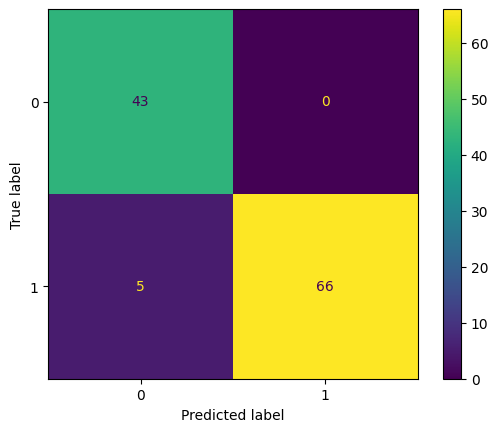

In [263]:
ConfusionMatrixDisplay.from_estimator(best_model_df_pca, test_features, test_targets)

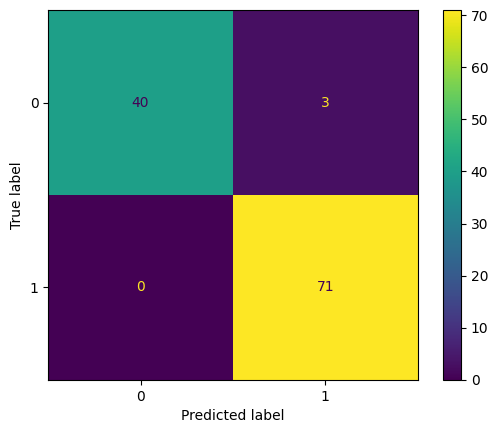

In [264]:
ConfusionMatrixDisplay.from_estimator(best_NB_original, test_features, test_targets)

# evaluating the model
lookgin at the metric results on the final best models:
  
Decision tree classifier with orignal with pca data:
The results are impressive, demonstrating that the model is highly effective at predicting and distinguishing between the two classes. While the model shows slight overfitting, with the test data results being marginally lower, the difference is negligible. Notably, the precision improved slightly in the test data.

Naive Bayes with orignal data:
The results look very good here as well, with all metrics showing slight improvement on the test data. This could have happened because of the randomness of the datasplit, at least we don't see any signs of over fitting.

outerloop model comparison:
The results from the Bernoulli Naive Bayes model on the original data are generally better than those of the decision tree. On average, the Bernoulli Naive Bayes model outperforms the decision tree. The results on all metrics were slightly better.
    
Confusion matrix comparison:  
We can see that the decision tree missed diagnosing cancer in five patients who actually had it, while it correctly identified all patients without cancer. Therefore, it made five mistakes, which could have been potentially fatal.  
The Naive Bayes model correctly diagnosed all patients with cancer, but it mistakenly diagnosed three people without cancer as having it. This mistake is less concerning because, in cases of a cancer diagnosis, it's likely that further tests would be conducted, whereas patients without cancer may not face the same level of follow-up.
  
conclusion:  
I will conclude by stating that, based on the results, the Bernoulli Naive Bayes model is the best for this dataset. On average, it outperformed the other five top models identified during the grid search. The best model also achieved higher F1 and recall scores, which are the most important metrics. Additionally, the confusion matrix shows that it made fewer mistakes, and those mistakes had less significant consequences.
  
things to consider:  
Hyperparameter Search Space: While we tuned the models using specific parameters, there could still be better configurations beyond the range we tested. Exploring a larger search space might uncover new peaks, leading to improved model performance. it was hard testing a very wide range of paramters without getting a too high run time, so i tested different intervals until i found an appropriate one.
  
randomness in the splits in the final comparison: When comparing the model's performance on training and test data, differences in results might stem from randomness in the data splits, especially in the final comparison. The best model could vary, especially when the differences are that small.

# sources
Scikit-learn developers. (2024). sklearn.pipeline.Pipeline. Scikit-learn documentation. Retrieved from https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html
  
Scikit-learn developers. (2024). sklearn.tree.DecisionTreeClassifier. Scikit-learn documentation. Retrieved from https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
  
Scikit-learn developers. (2024). sklearn.model_selection.GridSearchCV. Scikit-learn documentation. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html
  
Scikit-learn developers. (2024). sklearn.metrics.confusion_matrix. Scikit-learn documentation. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html
  
Scikit-learn developers. (2024). sklearn.naive_bayes.GaussianNB. Scikit-learn documentation. Retrieved from https://scikit-learn.org/1.5/modules/generated/sklearn.naive_bayes.GaussianNB.html